In [ ]:
# kernel - tvenv

In [69]:
import os
import glob
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [70]:
csv_files = glob.glob("dataset/*.csv")
print(csv_files[:2])

['dataset/PRICE_AND_DEMAND_202207_NSW1.csv', 'dataset/PRICE_AND_DEMAND_202206_NSW1.csv']


In [71]:
energy_df = pd.concat(pd.read_csv(file) for file in csv_files)
energy_df

,REGION,SETTLEMENTDATE,TOTALDEMAND,RRP,PERIODTYPE
0,NSW1,2022/07/01 00:05:00,8656.59,396.62,TRADE
1,NSW1,2022/07/01 00:10:00,8539.53,380.41,TRADE
2,NSW1,2022/07/01 00:15:00,8591.66,380.41,TRADE
3,NSW1,2022/07/01 00:20:00,8601.76,380.41,TRADE
4,NSW1,2022/07/01 00:25:00,8518.26,371.29,TRADE
...,...,...,...,...,...
1435,NSW1,2020/04/30 22:00:00,7823.41,21.76,TRADE
1436,NSW1,2020/04/30 22:30:00,7850.90,27.91,TRADE
1437,NSW1,2020/04/30 23:00:00,7696.18,28.33,TRADE
1438,NSW1,2020/04/30 23:30:00,7623.36,41.96,TRADE


In [72]:
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 248592 entries, 0 to 1439
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   REGION          248592 non-null  object 
 1   SETTLEMENTDATE  248592 non-null  object 
 2   TOTALDEMAND     248592 non-null  float64
 3   RRP             248592 non-null  float64
 4   PERIODTYPE      248592 non-null  object 
dtypes: float64(2), object(3)
memory usage: 11.4+ MB


In [73]:
energy_df.describe()

,TOTALDEMAND,RRP
count,248592.000000,248592.000000
mean,7609.351612,128.619204
std,1270.924160,289.366592
min,3957.320000,-1000.000000
25%,6682.177500,59.950000
50%,7470.850000,89.010000
75%,8324.510000,144.410000
max,13700.900000,15500.000000


In [74]:
for col in energy_df.columns:
    print(col + ": " + str(energy_df[col].nunique()))

REGION: 1
SETTLEMENTDATE: 248592
TOTALDEMAND: 189456
RRP: 36821
PERIODTYPE: 1


In [75]:
# dropping 2 columns with the same value throughout the dataframe
energy_df.drop(["REGION","PERIODTYPE"],axis=1,inplace=True)
energy_df.head()

,SETTLEMENTDATE,TOTALDEMAND,RRP
0,2022/07/01 00:05:00,8656.59,396.62
1,2022/07/01 00:10:00,8539.53,380.41
2,2022/07/01 00:15:00,8591.66,380.41
3,2022/07/01 00:20:00,8601.76,380.41
4,2022/07/01 00:25:00,8518.26,371.29


In [76]:
energy_df['SETTLEMENTDATE'] = pd.to_datetime(energy_df['SETTLEMENTDATE'])
energy_df.head(2)

,SETTLEMENTDATE,TOTALDEMAND,RRP
0,2022-07-01 00:05:00,8656.59,396.62
1,2022-07-01 00:10:00,8539.53,380.41


In [77]:
# verifying if the column has changed to datetime field
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 248592 entries, 0 to 1439
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   SETTLEMENTDATE  248592 non-null  datetime64[ns]
 1   TOTALDEMAND     248592 non-null  float64       
 2   RRP             248592 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 7.6 MB


In [78]:
energy_df.sort_values(by=["SETTLEMENTDATE"],inplace=True)
energy_df[100:105]

,SETTLEMENTDATE,TOTALDEMAND,RRP
100,2018-01-03 02:30:00,6140.19,53.63
101,2018-01-03 03:00:00,6075.40,53.14
102,2018-01-03 03:30:00,6046.01,54.98
103,2018-01-03 04:00:00,6115.91,54.98
104,2018-01-03 04:30:00,6241.05,56.23


#### Visualizing average daily demand for the entire period

In [80]:
# calculating average demand per day for visualization
vis_df = energy_df.copy()
vis_df['SD_DATE'] = vis_df['SETTLEMENTDATE'].dt.date
vis_df = vis_df.groupby('SD_DATE')['TOTALDEMAND'].sum().reset_index()
vis_df.head(5)

,SD_DATE,TOTALDEMAND
0,2018-01-01,346532.75
1,2018-01-02,378965.84
2,2018-01-03,360065.93
3,2018-01-04,362772.07
4,2018-01-05,385022.79


In [81]:
vis_df = vis_df.set_index("SD_DATE")
vis_df.head(5)

,TOTALDEMAND
SD_DATE,
2018-01-01,346532.75
2018-01-02,378965.84
2018-01-03,360065.93
2018-01-04,362772.07
2018-01-05,385022.79


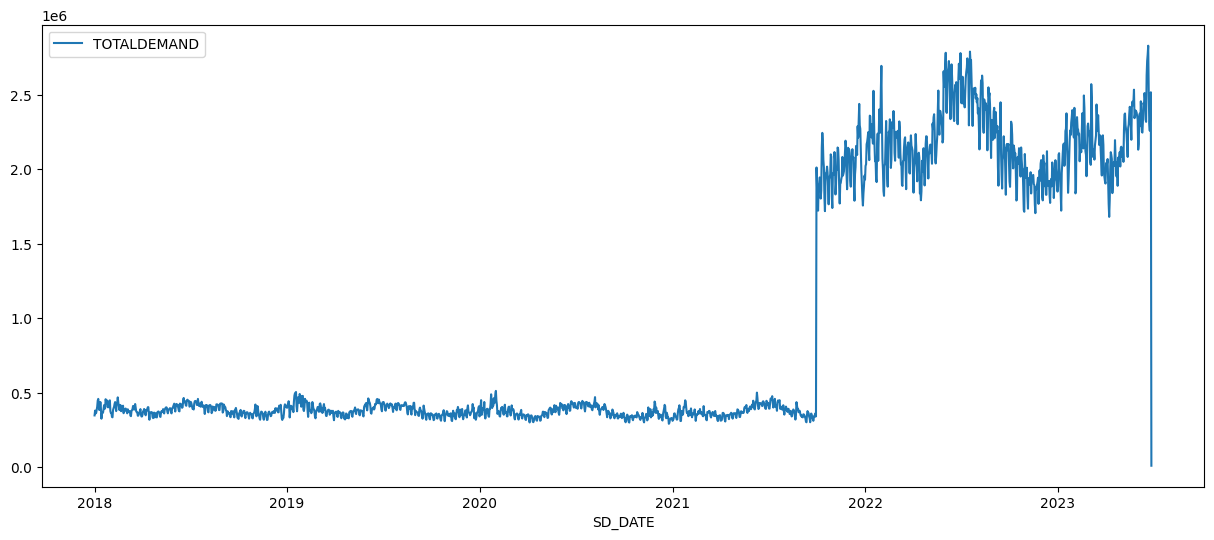

In [82]:
vis_df.plot(figsize=(15, 6))
plt.show()

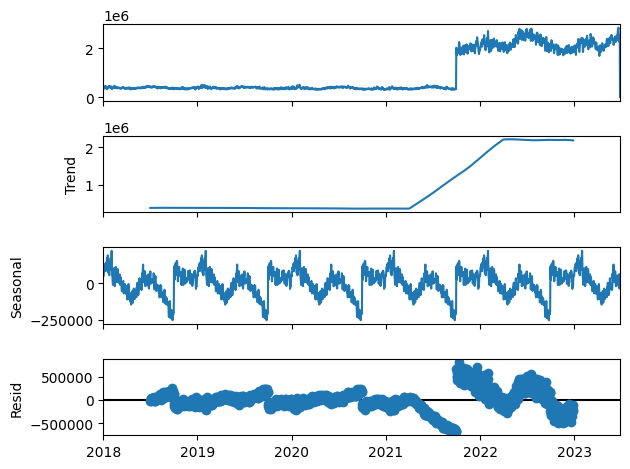

In [83]:
decomposition = sm.tsa.seasonal_decompose(vis_df,period=365)
fig = decomposition.plot()
plt.show()

#### Extracting more features for modelling

In [85]:
energy_df['Weekday'] = energy_df['SETTLEMENTDATE'].dt.weekday
energy_df['Hour'] = energy_df['SETTLEMENTDATE'].dt.hour
energy_df['Minute'] = energy_df['SETTLEMENTDATE'].dt.minute
energy_df['Quarter'] = energy_df['SETTLEMENTDATE'].dt.quarter
energy_df['Time'] = (energy_df['Hour'] * 60 + energy_df['Minute']) / 60
energy_df['Month'] = energy_df['SETTLEMENTDATE'].dt.month

In [92]:
# importing holidays in NSW

import holidays

energy_df['Year'] = energy_df['SETTLEMENTDATE'].dt.year
years = list(energy_df['Year'].unique())
nsw_holidays = holidays.Australia(state="NSW",years=years)
next(iter(nsw_holidays))

datetime.date(2018, 3, 30)

In [98]:
# marking holidays in NSW
energy_df['SETTLEMENTDATE_Date'] = energy_df['SETTLEMENTDATE'].dt.date
def label_holidays(date):
    if date in nsw_holidays.keys():
        return 1
    else:
        return 0
    
energy_df['Holiday'] = energy_df['SETTLEMENTDATE_Date'].apply(label_holidays)

In [100]:
energy_df.loc[energy_df['Holiday']==1]

,SETTLEMENTDATE,TOTALDEMAND,RRP,Year,Weekday,Hour,Minute,Quarter,Time,Month,Holiday,SETTLEMENTDATE_Date
0,2018-01-01 00:30:00,6912.25,91.86,2018,0,0,30,1,0.500000,1,1,2018-01-01
1,2018-01-01 01:00:00,6745.63,88.83,2018,0,1,0,1,1.000000,1,1,2018-01-01
2,2018-01-01 01:30:00,6466.06,73.62,2018,0,1,30,1,1.500000,1,1,2018-01-01
3,2018-01-01 02:00:00,6279.80,71.49,2018,0,2,0,1,2.000000,1,1,2018-01-01
4,2018-01-01 02:30:00,6177.31,69.27,2018,0,2,30,1,2.500000,1,1,2018-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...
3450,2023-06-12 23:35:00,8127.34,89.00,2023,0,23,35,2,23.583333,6,1,2023-06-12
3451,2023-06-12 23:40:00,8202.45,99.38,2023,0,23,40,2,23.666667,6,1,2023-06-12
3452,2023-06-12 23:45:00,8108.14,89.00,2023,0,23,45,2,23.750000,6,1,2023-06-12
3453,2023-06-12 23:50:00,8041.27,88.96,2023,0,23,50,2,23.833333,6,1,2023-06-12


In [102]:
# dropping year and date columns as they were extracted to support other columns and not really needed
energy_df.drop(['SETTLEMENTDATE_Date','Year'],axis=1,inplace=True)
energy_df.head(5)

,SETTLEMENTDATE,TOTALDEMAND,RRP,Weekday,Hour,Minute,Quarter,Time,Month,Holiday
0,2018-01-01 00:30:00,6912.25,91.86,0,0,30,1,0.5,1,1
1,2018-01-01 01:00:00,6745.63,88.83,0,1,0,1,1.0,1,1
2,2018-01-01 01:30:00,6466.06,73.62,0,1,30,1,1.5,1,1
3,2018-01-01 02:00:00,6279.80,71.49,0,2,0,1,2.0,1,1
4,2018-01-01 02:30:00,6177.31,69.27,0,2,30,1,2.5,1,1


In [104]:
# checking if all columns are in the form we need
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 248592 entries, 0 to 7775
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   SETTLEMENTDATE  248592 non-null  datetime64[ns]
 1   TOTALDEMAND     248592 non-null  float64       
 2   RRP             248592 non-null  float64       
 3   Weekday         248592 non-null  int32         
 4   Hour            248592 non-null  int32         
 5   Minute          248592 non-null  int32         
 6   Quarter         248592 non-null  int32         
 7   Time            248592 non-null  float64       
 8   Month           248592 non-null  int32         
 9   Holiday         248592 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int32(5), int64(1)
memory usage: 16.1 MB
